In [1]:
import eyepy as ep
import imageio
import matplotlib.pyplot as plt

from skimage.feature import hog, canny, plot_matches
from skimage import exposure

import numpy as np
from PIL import Image

import imageio

In [2]:
def center_crop(img, size):
    center = img.shape[0] // 2, img.shape[1] // 2
    
    height_range = center[0] - size[0] // 2, center[0] + size[0] // 2
    width_range = center[1] - size[1] // 2, center[1] + size[1] // 2
    return img[height_range[0]:height_range[1],
               width_range[0]:width_range[1],
               :]

In [3]:
with ep.io.VolReader("/home/morelle/data/oct_raw/ExportRAWanonymized/67007_20190515.vol") as reader:
    nir_img = reader.read_nir()
    
cfp_img = imageio.imread("/home/morelle/data/oct_raw/ExportRAWanonymized/HS00+0EZ.003.BMP")
cfp_img = center_crop(cfp_img, (cfp_img.shape[0], cfp_img.shape[0]))


im = Image.fromarray(cfp_img)
im.thumbnail(nir_img.shape, Image.ANTIALIAS)

cfp_img = np.array(im)

In [11]:
nir_features

array([[ 505, 1230],
       [1330,  239],
       [ 197,  280]])

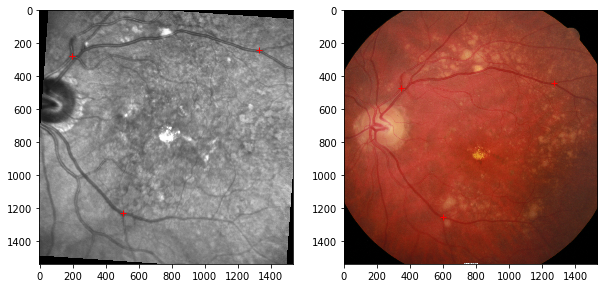

In [4]:
nir_features = np.array([[505, 1230], 
                         [1330, 239], 
                         [197,280]]
                       )
cfp_features = np.array([[602, 1250], 
                         [1275, 439], 
                         [343,473]]
                       )

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,20))
ax1.imshow(nir_img, cmap="gray")
ax2.imshow(cfp_img, cmap="gray")
ax1.plot(nir_features[:,0], nir_features[:,1], "r+")
ax2.plot(cfp_features[:,0], cfp_features[:,1], "r+")

In [7]:
from skimage.transform import AffineTransform, warp

model = AffineTransform()
model.estimate(cfp_features, nir_features)
transformed_cfp = warp(cfp_img, model.inverse, )

In [8]:
from skimage.color import gray2rgb
from skimage.segmentation import checkerboard_level_set

def to_rgb_with_alpha(img, channels_last=True, float_scale=True):
    
    if img.min() < 0:
        msg = "Negative values are not allowed in image"
        raise ValueError(msg)
        
    # Integer data should be scaled 0-255
    if img.dtype == int:
        if img.max() > 255:
            msg = "Images of type int have to be scaled 0 to 255"
        
    # Float data should be scaled 0-1
    if img.dtype == float:
        if img.max() > 1.0:
            msg = "Images of type float have to be scaled 0.0 to 1.0"
            raise ValueError(msg)
    
    if float_scale and img.dtype == int:
        img /= 255
        
    if not float_scale and img.dtype == float:
        img = (img*255).astype(int)
        
    
    img = gray2rgb(img, alpha=True)
    return img
        
        

def plot_registration_comparison(img1, img2, square_size=200, figsize=(10,10)):
    fig, ax = plt.subplots(1,1, figsize=figsize)
    
    img1 = to_rgb_with_alpha(img1, float_scale=True)
    img2 = to_rgb_with_alpha(img2, float_scale=True)
    
    alpha = checkerboard_level_set(img1.shape[:-1], square_size).astype(float)
    #alpha[[np.arange(img1.shape[0])],
    #      np.arange(0, img1.shape[1], gridsize[1])] = 1.0
    
    
    #img1[..., -1] = alpha.astype(float)
    img2[..., -1] = alpha#abs(alpha-1)
    ax.imshow(img1)
    ax.imshow(img2)

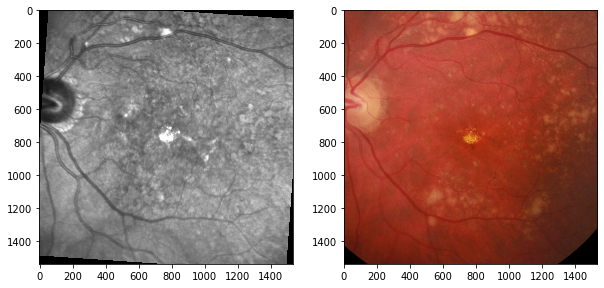

In [9]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,20))
ax1.imshow(nir_img, cmap="gray")
ax2.imshow(transformed_cfp)

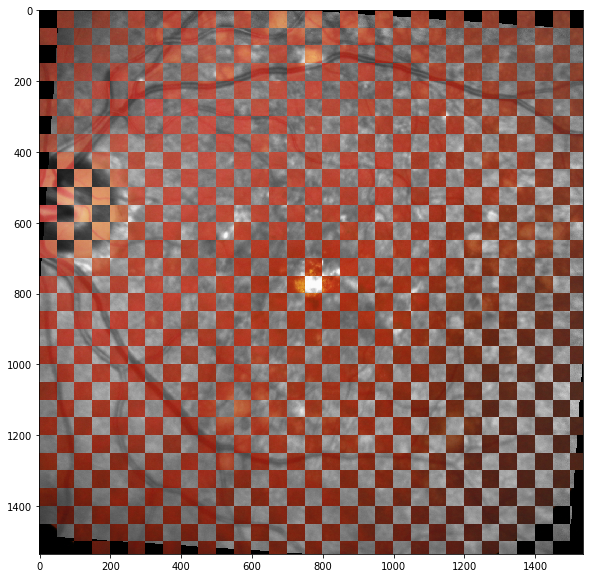

In [10]:
plot_registration_comparison(nir_img, transformed_cfp, square_size=50)